# Homework 2 : CUAHSI VU : Snow Hydrology

We'll use the setup from the `homework_2_B_setup.ipynb` notebook for this exercise. If you think that you comprised that setup in a previous exercise, just rerun `homework_2_B_setup.ipynb` before continuing.

As before, remember that you want to save your notebooks in a place other than the `examples` directory tree, because files you save there may be deleted and overwritten the next time you start your virtual machine. Save your files somewhere in the `work` directory tree: `work/homework_2` would be a great place for them. So click on "_File --> Save Notebook As..._" and save this notebook as `work/homework_2/homework_2_C_exercise_1.ipynb` before you continue. If things go hopelessly wrong, you can always start over again with the original notebook in your `examples` directory tree.

## C. Homework 2 Exercise 1

This first exercise is mostly just a walk-through that will demonstrate the effects of wind speed on the snow simulations. To do this, we will 
* perform a baseline simulation with the original forcing data, 
* read the original forcing file into an `xarray Dataset`, 
* modify the wind speed for one of the hrus,
* write the new forcings to a new file, and 
* perform a second simulation. 

To make sure that this second simulation uses the new forcing file, we need to modify the SUMMA input file that points to the forcing file to be used (the [forcing file list](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/#list-of-forcing-files-file)). 

In addition to all this, we will also compare the simulations with observations. We will show an example below. Don't worry, you'll get to do all this yourself in following notebooks.

### Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt # if you want to do some plotting using matplotlib (optional)
import numpy as np # provide some mathematical functions
import xarray as xr # read, write, manipulate and analyze NetCDF files
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

import pysumma as ps

In [3]:
filemanager = './umpqua/settings/snow_fileManager.txt'
executable = 'summa.exe'

### Effect of wind speed on snow simulations

We first perform a simulation using the baseline forcing data (this is the same simulation as in `homework_2_B_setup.ipynb`. To do this, we create a SUMMA simulation object and run the model and tage the simulation with the identifier `baseline`.

In [4]:
s = ps.Simulation(executable, filemanager)
s.run('local', run_suffix='baseline')

When we plot the SWE for this simulations, we see that the snow in the clearing and in the forest reach about the same maximum and that there it persists longer in the forest, which is somewhat counter-intuitive:

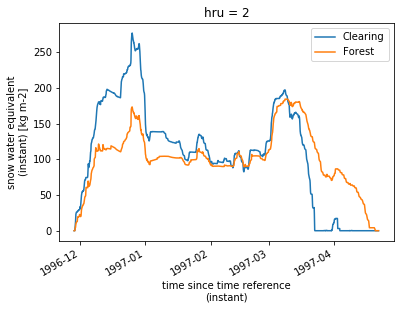

In [8]:
s.output['scalarSWE'].sel(hru=1).plot(label='Clearing')
s.output['scalarSWE'].sel(hru=2).plot(label='Forest')
plt.legend()

Pascal Storck took SWE measurements in the clearing and the forest, which are available to you in `/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/data/contents/umpqua/observations/Storck_9697_SWE_obs.nc`. Can you read this file with

In [6]:
swe_file = './umpqua/observations/Storck_9697_SWE_obs.nc'
swe_obs = xr.open_dataset(swe_file)

When we plot the observations with the model simulations

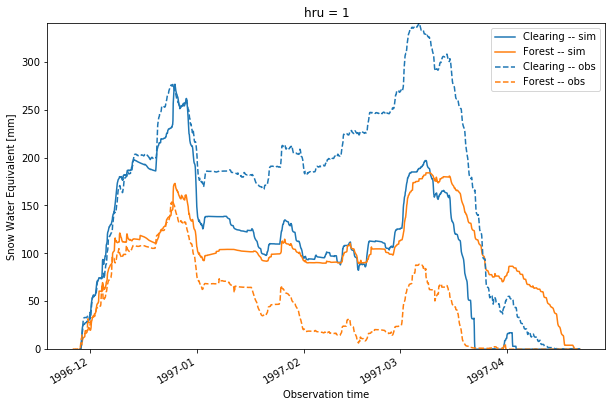

In [10]:
plt.figure(figsize=(10,6))
s.output['scalarSWE'].sel(hru=1).plot(label='Clearing -- sim', 
                                       color=cycle[0], linestyle='-')
s.output['scalarSWE'].sel(hru=2).plot(label='Forest -- sim',
                                       color=cycle[1], linestyle='-')
swe_obs['SWE'].sel(hru=0).plot(label='Clearing -- obs',
                             color=cycle[0], linestyle='--')
swe_obs['SWE'].sel(hru=1).plot(label='Forest -- obs',
                             color=cycle[1], linestyle='--')
max_swe = max(s.output['scalarSWE'].max(), swe_obs['SWE'].max())
plt.ylim(0,max_swe)
plt.legend()

While that does not look too bad for the clearing, the simulations at the forested site don't look right. In the observations we see much less accumulation under the tree canopy, but we do not see this effect in the simulations.

One of the reasons for this is that we are using the same meteorological forcings for both the clearing and forested site. 

Let's take a look at the forcings. To do this, open the forcing file for this simulation and read the file into an `xarray Dataset` object. Note that the name of the forcing file is stored in the forcing list file. The location of that file is

In [35]:
print(s.force_file_list.original_path)

./umpqua/settings/snow_zForcingFileList.txt


To change the path of the forcing file we have to do a bit more work. Because SUMMA allows for multiple forcing files we have to select them out by index. We can look at each entry in the forcing file list with the `options` attribute. Each `option` in the forcing file list has a `name` and a `value`. The `name` is the complete forcing file path and the value is the actual data in the forcing file. Let's look at each of them here

In [20]:
force_file_obs = s.force_file_list.options[0].name
force_file_obs

'./umpqua/forcing/Storck_AboveCanopyPP_9697_anderson.nc'

If you look in that file, you will see that the name of the forcing file is `Storck_AboveCanopyPP_9697.nc`. We can actually get the data by accessing the value directly

In [22]:
force_obs = s.force_file_list.options[0].value
force_obs

<xarray.Dataset>
Dimensions:    (hru: 2, time: 1770)
Coordinates:
  * time       (time) datetime64[ns] 1996-11-25T21:59:59.999996640 ... 1997-04-22T08:00:00.000003360
Dimensions without coordinates: hru
Data variables:
    hruId      (hru) int32 ...
    latitude   (hru) float64 ...
    longitude  (hru) float64 ...
    data_step  timedelta64[ns] ...
    LWRadAtm   (time, hru) float64 ...
    SWRadAtm   (time, hru) float64 ...
    airpres    (time, hru) float64 ...
    airtemp    (time, hru) float64 ...
    pptrate    (time, hru) float64 ...
    spechum    (time, hru) float64 ...
    windspd    (time, hru) float64 ...
Attributes:
    dataset_orig_path:  /d2/anewman/summa/summaTestCases/testCases_data/input...
    history:            Tue Sep 27 21:53:13 2016: ncrename -d nHRU,hru ./inpu...
    NCO:                "4.6.0"

We can quickly examine the differences in the forcings between the two hrus by subtracting the forcing data for the two hrus and taking the mean (just showing some xarray features). 

In [23]:
(force_obs.isel(hru=0)-force_obs.isel(hru=1)).mean()

<xarray.Dataset>
Dimensions:    ()
Data variables:
    hruId      float64 -1.0
    latitude   float64 0.0
    longitude  float64 0.0
    data_step  timedelta64[ns] 00:00:00
    LWRadAtm   float64 0.0
    SWRadAtm   float64 0.0
    airpres    float64 0.0
    airtemp    float64 0.0
    pptrate    float64 0.0
    spechum    float64 0.0
    windspd    float64 -1.188

As you can see, subtracting the two hrus in the `xarra Dataset` will actually subtract all the forcing fields that are in that dataset and the mean difference is 0 for all meteorological variables.

Now keep in mind that SUMMA expects that the forcing variables are specified above the top canopy layer. For most of the forcing variables it may make not much difference whether you take the measurement in a (large) clearing or above the tree canopy (to first order). However, one forcing variable that will definitely be different is the wind speed, which is much lower nearer to the ground in a clearing then above the tree canopy. So using the same wind speed for both simulations is not very realistic. 

Now we can actually estimate the mean difference in the wind speed in the clearing and above the tree canopy by making some assumptions about the wind profile near the surface (see lectures). In this case, it turns out that the wind speed above the forest is about 1.6 times greater than the wind speed in the clearing. So let's adjust the wind speed for hru 1 and rerun the simulations.

To do so, we make a copy of the `force_obs` dataset and will write that to a new input file. Note that in `xarray` you need to use `.copy(deep=True)` when you make the copy. Otherwise the original dataset (`force_obs`) will also be modified when you change your copy (`force_wind`).

In [26]:
force_wind = force_obs.copy(deep=True)
force_wind['windspd'].loc[{'hru': 1}] *= 1.6

Let's plot the new wind speeds to make sure they now differ

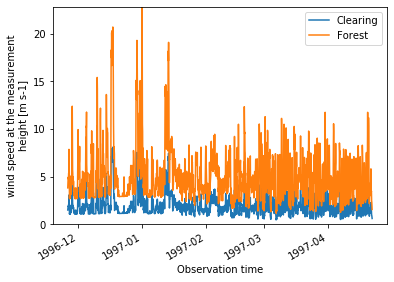

In [27]:
force_wind['windspd'].isel(hru=0).plot(label='Clearing')
force_wind['windspd'].isel(hru=1).plot(label='Forest')
plt.ylim(0,force_wind['windspd'].max())
plt.legend()

We now want to write this to file and do a new simulation. We first create a new filename for the new file (we replace the '9697' in the original file name by '9697_rescaled_wind')

In [28]:
force_file_wind = force_file_obs.replace('9697', '9697_rescaled_wind')

We then write the dataset to a NetCDF file (SUMMA expects the file in 'NETCDF3_CLASSIC' format)

In [34]:
force_wind.to_netcdf(force_file_wind, format='NETCDF3_CLASSIC')

Now that we have the data written to the NetCDF file we need to write out the new forcing file list so that SUMMA can find it. We will first set the forcing file list to use the new forcing file that we just wrote out. Then we will write this back out as a new forcing file list.

In [75]:
s.force_file_list.options[0].name = force_file_wind
new_force_file = s.force_file_list.original_path.replace('.txt', '_rescaled_wind.txt')
s.force_file_list.write(new_force_file)

With our new forcing file list written out we will also write out a new file manager. This helps to keep all of our runs separated so that we can go back and compare them more easily. Just as with the forcing file list, we will update the entry for the forcing file list in the file manager, and then write that out to a new file.

In [76]:
new_filemanager = s.manager_path.replace('.txt', '_rescaled_wind.txt') 
s.manager['forcing_file_list'] = new_force_file.split('/')[-1]
s.manager.write(new_filemanager)

Finally, our new file manager (with the new entry for the rescaled wind forcing) can be used to create a new `Simulation` object. We will create it and verify that we are using the new forcing file with the rescaled wind.

In [77]:
s_windy = ps.Simulation(executable, new_filemanager)

In [81]:
print(s_windy.force_file_list)

'Storck_AboveCanopyPP_9697_rescaled_wind_anderson.nc'


OK - now we are all set. Let's do the new simulation with the rescaled wind

In [79]:
s_windy.run('local', run_suffix='rescaled_wind')

And let's replot the simulations and observations

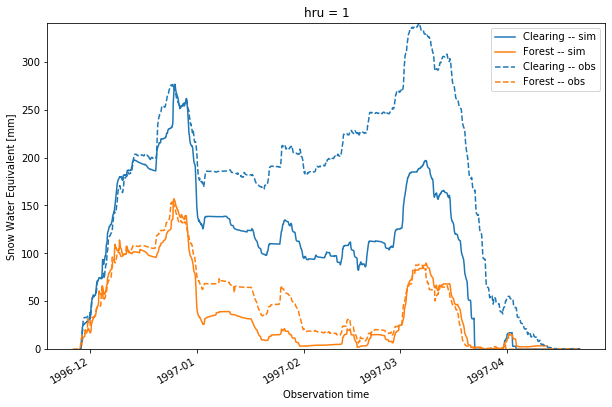

In [82]:
plt.figure(figsize=(10,6))
s_windy.output['scalarSWE'].sel(hru=1).plot(label='Clearing -- sim', 
                                             color=cycle[0], linestyle='-')
s_windy.output['scalarSWE'].sel(hru=2).plot(label='Forest -- sim',
                                             color=cycle[1], linestyle='-')
swe_obs['SWE'].sel(hru=0).plot(label='Clearing -- obs',
                             color=cycle[0], linestyle='--')
swe_obs['SWE'].sel(hru=1).plot(label='Forest -- obs',
                             color=cycle[1], linestyle='--')
max_swe = max(s.output['scalarSWE'].max(), swe_obs['SWE'].max())
plt.ylim(0,max_swe)
plt.legend()

While that still isn't perfect, these simulations look a lot better. We now get snow interception and increased sublimation from the canopy, which greatly reduces the snow pack below the canopy.

**Keep in mind that the file with the forcing file list now points to the rescaled wind file. If you want to rerun with any other forcing you will need to make sure that the file reported in `forcing_file_list` points to the right input file.**

You can navigate to this file in the file browser to the left.

In addition, the file with the updated forcing will not be overwritten or removed when you rerun the setup in `homework_2_B_setup.ipynb` until you explicitly overwrite it again (for example by rerunning this notebook).

Finally a few hints and things to keep in mind: It is easy to get confused with the model setup and the simulations. If you make changes to the forcings and the simulations do not change, make sure that your simulation object actually reads the right forcing file.

All the forcing files should end up in the directory : `/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/
data/contents/umpqua/forcing/`
You can inspect that directory in the file browser to the left (you can also do that in a terminal if you are familiar with unix).

To make sure that the right file is actually being read, you can inspect the `forcing_file_list`, which is at:
`/home/jovyan/work/05adaf5618ee4dbbbf04195db376cbb4/05adaf5618ee4dbbbf04195db376cbb4/
data/contents/umpqua/settings/snow_zForcingFileList.txt`

Keep in mind that commands in a jupyter notebook can be executed in any order, but that that may affect the results. When things don't make sense, re-install the setup for homework 2 (execute the cells in `homework_2_B_setup.ipynb`) and rerun this notebook. To make sure you start afresh, you should also restart the kernel (so there are no old versions in memory). You can do this by going to `Kernel --> Restart Kernel...` and re-executing the notebook cells or selecting `Kernel --> Restart Kernel and Run All Cells`. Normally you would not redo all the model simulations every time, but since the simulations are short, we'll use that method for now.

Before closing out of this notebook it is good practice to close the open datasets. This prevents errors if other notebooks or SUMMA simulations try to access the same data.

In [84]:
s.output.close()
s_windy.output.close()

## On to the next step

That's it for the first part of the second homework as far as the model simulations go. Prof. Lundquist will talk more about the analysis that you need to do on these simulations. You can do the analysis here in this notebook if python is your analysis software of choice or you can upload your output to HydroShare (in NetCDF or csv format) to do additional analysis.

Save this notebook and close the tab. You can also right-click on the file in the left panel if it has a green dot next to it and select "_Shutdown kernel_" from the popup menu to stop the python session that is executing the commands in this notebook. Then open the next notebook: 
`work/homework_2/homework_2_D_exercise_2.ipynb`.